# Huggingface is not just for NLP

In [1]:
from transformers import pipeline

vision_classifier = pipeline(model="google/vit-base-patch16-224")
preds = vision_classifier(
    images="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
)

In [1]:
preds = [{"score": round(pred["score"], 4), "label": pred["label"]} for pred in preds]
preds

[{'score': 0.4403, 'label': 'lynx, catamount'},
 {'score': 0.0343,
  'label': 'cougar, puma, catamount, mountain lion, painter, panther, Felis concolor'},
 {'score': 0.0321, 'label': 'snow leopard, ounce, Panthera uncia'},
 {'score': 0.0235, 'label': 'Egyptian cat'},
 {'score': 0.023, 'label': 'tiger cat'}]

# Fine Tune

In [1]:
from datasets import load_dataset
food = load_dataset("food101", split="train[:1000]", cache_dir=".")
food = food.train_test_split(test_size=0.2)

Resolving data files:   0%|          | 0/32 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

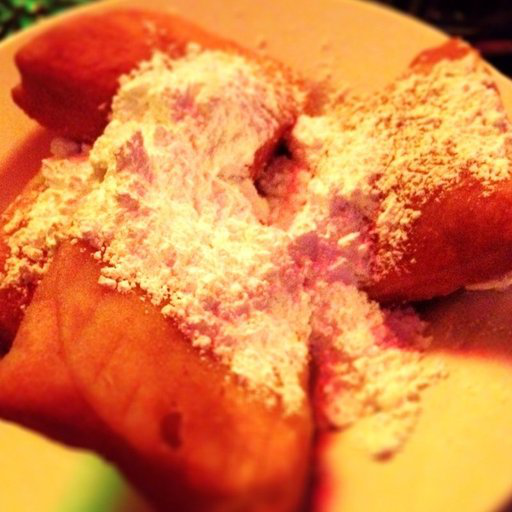

In [2]:
food["train"][0]["image"]

In [14]:
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

image_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

def transforms(examples):
    examples["pixel_values"] = [image_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [ ]:
dir(image_processor)

In [4]:
food = food.with_transform(transforms)

In [5]:
from transformers import DefaultDataCollator

In [6]:
data_collator = DefaultDataCollator()

In [7]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [12]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

labels = food["train"].features["label"].names

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels)).to("cuda")

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/home/alper/miniconda3/envs/chirp/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
